In [1]:
sys.argv = ['-f'] # override any sysargs given by ipy or jupyter and allow this to be run inside an ipynb

In [2]:
import scipy.io
import os
import numpy as np
from loader import load_all_mats
from logger import logger
logger.setLevel('INFO')

In [3]:
# Load all data:
data = load_all_mats()

2021-05-09 22:13:31 Connors-MacBook-Pro.local logger[21666] INFO Loading all data . . .
2021-05-09 22:13:55 Connors-MacBook-Pro.local logger[21666] NOTICE All data loaded.


Text(0.5, 1.0, 'Microphone 1-Sided Amp. Spectrum for 60k-15mm-100um, Channel 0, Section 0')

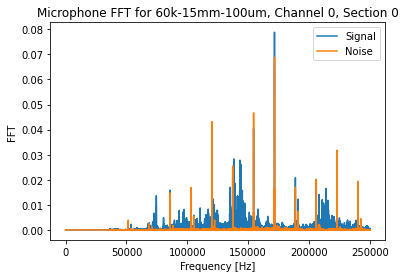

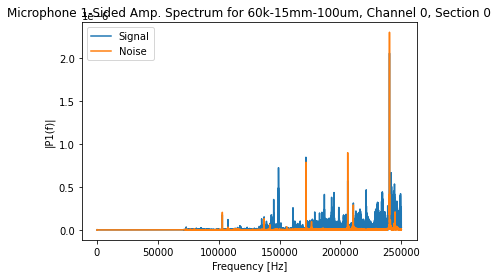

In [42]:
import matplotlib.pyplot as plt
import numpy as np

exp = [*data.values()][0]
section = exp.data[0].sections[0]

# Display FFT Results:
sig_fft = section.AE_FFT.numpy()
bg_fft = section.AE_FFT_BG.numpy()

plt.figure()
plt.plot(sig_fft[1,:],sig_fft[0,:])
plt.plot(bg_fft[1,:],bg_fft[0,:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT')
plt.legend(('Signal','Noise'))
plt.title(f'Microphone FFT for {exp.dir_name}, Channel 0, Section 0')

# One-Sided Amp. Spectrum:
L = sig_fft[0,:].size//2*2
P2 = np.abs(sig_fft[0,:]/L)
P1 = P2[0:int(L/2)]
P1[1:-2] = 2*P1[1:-2]
P1_f = sig_fft[1,0:-1:2]

L_bg = bg_fft[0,:].size//2*2
P2_bg = np.abs(bg_fft[0,:]/L_bg)
P1_bg = P2_bg[0:int(L_bg/2)]
P1_bg[1:-2] = 2*P1_bg[1:-2]
P1_bg_f = bg_fft[1,0:-1:2]

plt.figure()
plt.plot(P1_f,P1)
plt.plot(P1_bg_f,P1_bg)
plt.xlabel('Frequency [Hz]')
plt.ylabel('|P1(f)|')
plt.legend(('Signal','Noise'))
plt.title(f'Microphone 1-Sided Amp. Spectrum for {exp.dir_name}, Channel 0, Section 0')

# Power Spectral Density:
# must subtract PSD not FFT (just like how you can add var, not sigma)



In [44]:
# Plot Section-wise Spectrogram for an experiment:
import matplotlib.pyplot as plt
import numpy as np

exp = [*data.values()][0]
# Grab FFT data for all channels:
ns = np.cumsum([1 for d in exp.data for s in d.sections])
print(ns)

sig_ffts = [s.AE_FFT.numpy() for d in exp.data for s in d.sections]


bg_ffts = [s.AE_FFT_BG.numpy() for d in exp.data for s in d.sections]



In [ ]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()